In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import string   # Pour la ponctuation
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import manifold, decomposition
from sklearn.manifold import TSNE
from sklearn import cluster, metrics
import re
from wordcloud import WordCloud
import gensim
import plotly.graph_objs as go
from plotly.offline import iplot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras
import tensorflow_hub as hub
from gensim.models import LdaModel
from gensim import corpora

#LDA
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import os # Pour supprimer les warnings

%load_ext pycodestyle_magic

pd.options.display.max_columns = None

2022-07-13 15:53:47.553592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 15:53:47.553620: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
print(f'Le fichier description contient {data.shape[0]} lignes et {data.shape[1]} colonnes')

Le fichier description contient 1050 lignes et 15 colonnes


In [3]:
data.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [5]:
def traitement_NA_par_type(df):
    '''
    Fonction permettant de sortir un tableau classé de l'ensemble des features comportant des NA, par nombre et %
    ----------
    Paramètre:
    - df : dataframe
    ----------
    Return:
    - une visualisation d'un tableau avec la liste des features et leurs taux de remplissage
    '''
    df_NA = pd.concat([df.isna().sum(),
                       ((df.isna().sum()/data.isna().count())*100),
                       df.dtypes], axis=1, keys=['Total_NA', '%_de_NA', 'Type'])
    df_NA.sort_values(['Type','Total_NA'],ascending=[True,False])

    display(df_NA[df_NA['Total_NA'] > 0])

In [6]:
traitement_NA_par_type(data)

Total_NA    %_de_NA     Type
retail_price                   1   0.095238  float64
discounted_price               1   0.095238  float64
brand                        338  32.190476   object
product_specifications         1   0.095238   object

Les valeurs des NA ne concernent pas les descriptions.

In [7]:
# Vérification des commentaires en double
len(data['description'].unique())

1050

Il n'existe aucun commentaire en double.

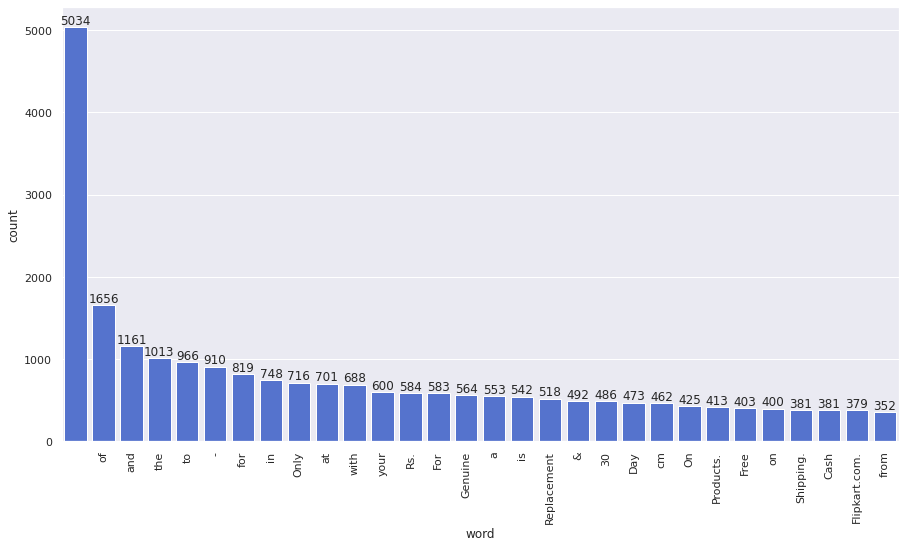

In [8]:
# Exploration des caractères les plus présents avant transformation

texte = list(data['description'])  # Récupération des descriptions dans une liste
texte = "".join(texte)             # Création d'un string unique contenant tous les mots
liste_de_mot = texte.split(' ')       # Création d'une liste avec tous les mots
comptage = Counter(liste_de_mot)   # Comptage du nombre de mots

# Affichage des mots les plus communs
sns.set()
plt.rcParams["figure.figsize"] = (15,8)
comptage = pd.DataFrame(comptage.most_common(30),columns=['word','count'])
ax = sns.barplot(x='word',y='count',data=comptage,color='royalblue')
_ = ax.bar_label(ax.containers[0])
_ = plt.xticks(rotation=90)

Il est peu pertinent de réaliser une liste des mots les plus présents avant nettoyage. En effet, beaucoup de stopword ressortent.

## Traitement des catégories cibles

In [9]:
# Traitement des catégories

data['First_category'] = data.product_category_tree.str.split(' >> ', expand=True)[0]
data['First_category'] = data['First_category'].str[2:]  # Suppression des 2 premiers caractères ["

data['Second_category'] = data.product_category_tree.str.split(' >> ', expand=True)[1]
data['Third_category'] = data.product_category_tree.str.split(' >> ', expand=True)[2]

data.head(5)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications   First_category  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing   

          Second_category    Third_category  
0  Curtains & Accessories          Curtains  
1        Baby Bath & Skin  Baby Bath Towels  
2        Baby Bath & Skin  Baby Bath Towels  
3               Bed Linen         Bedsheets  
4               Bed Linen         Bedsheets

In [10]:
print(f"Le nombre de catégories 1er niveau est {data['First_category'].nunique()}")
print(f"Le nombre de catégories 2nd niveau est {data['Second_category'].nunique()}")
print(f"Le nombre de catégories 3eme niveau est {data['Third_category'].nunique()}")

Le nombre de catégories 1er niveau est 7
Le nombre de catégories 2nd niveau est 63
Le nombre de catégories 3eme niveau est 246


In [11]:
categories = list(data['First_category'].unique())

In [12]:
data.groupby('First_category').count()['uniq_id']

First_category
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: uniq_id, dtype: int64

## Nettoyage du texte sur les descriptions

In [13]:
# Téléchargement des packages

nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to /home/agent/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /home/agent/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [14]:
# Définition des stopwords et du Lemmatizer

stopwords = nltk.corpus.stopwords.words('english') ## Mots apparaissant fréquement (articles, pronoms, etc)

lemmatizer = WordNetLemmatizer()  # Lemmatizer qui permet de ne conserver que la racine des mots

print(f"Le nombre de stop_words est de {len(stopwords)}.")

Le nombre de stop_words est de 179.


In [15]:
def Preprocessing_nettoyage(text):
    '''
    Fonction de nettoyage avec dans l'ordre:
    - Mise en minuscule et suppression de la ponctuation (attention, dans certain cas, la ponctuation ne doit pas être supprimée)
    - Tokenisation du texte
    - Suppression des stopwords et des mots inférieurs à 3 caractères
    - Lemmatisation des tokens - préserve le sens (résultat non conjugé et non accordé) 
    - Regroupement des mots uniquement si ils sont composés de lettre alphabétique (supp des références par ex R23456789)
    ----------------------------
    Sortie : une liste avec les commentaires nettoyés
    '''
    preprocessing_list = []
    
    for phrase in text:
        phrase_sans_ponctuation = ''.join([i.lower() for i in phrase if i not in string.punctuation])
        
        tokenize_phrase = nltk.tokenize.word_tokenize(phrase_sans_ponctuation)
        
        mots_lemmatize = (lemmatizer.lemmatize(m) for m in tokenize_phrase)  # Lemmatisation vs stemmatisation (conservation de la racine uniquement)

        mots_sans_stopwords = [i for i in mots_lemmatize if i not in stopwords and len(i) > 3]
        
        phrases_nettoyees = ' '.join(m for m in mots_sans_stopwords if m.isalpha())
        
        preprocessing_list.append(phrases_nettoyees)        

    return preprocessing_list 

In [16]:
# Application du nettoyage sur la colonne descrition
data['descriptions_nettoyees'] = Preprocessing_nettoyage(data['description'])

In [17]:
# Test d'un commentaire avant et après nettoyage
print('Phrase initiale : ' + data['description'][1])
print('-------------------------------------------------------------------------------------------')
print('Phrase nettoyée : ' + data['descriptions_nettoyees'][1])

Phrase initiale : Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel
-------------------------------------------------------------------------------------------
Phrase nettoyée : specification sathiyas cotton bath towel bath towel yellow blue bath towel feature machine washable material cotton design self design general brand sathiyas type bath towel model name sathiyas cotton bath towel ideal woman girl model color yellow blue size mediam dimension length inch width inch number content sale package sale package bath towel


### Représentation des mots les plus courants

In [18]:
# Calcul des mots les plus courants
liste_de_mot_temp = "".join(data['descriptions_nettoyees'].to_list())
liste_de_mot = liste_de_mot_temp.split(' ')   
comptage = Counter(liste_de_mot)   # Comptage du nombre de mots

df_comptage = pd.DataFrame(comptage.most_common(30),columns=['word','count'])

# # Affichage des mots les plus communs
# for mot in comptage.most_common(30):
#     print(f"{mot[0]} :  {mot[1]}")

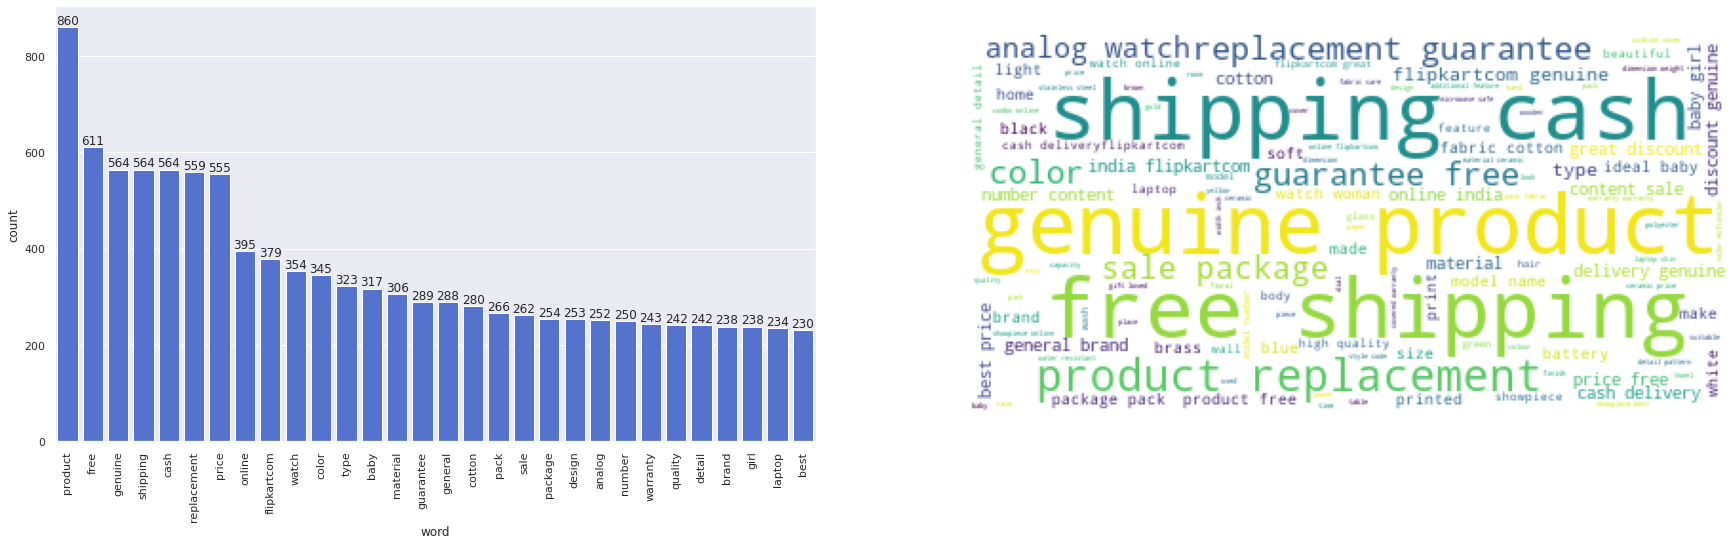

In [19]:
fig = plt.figure(figsize=(30,8))


ax1 = plt.subplot(121)
ax1 = sns.barplot(x='word',y='count',data=df_comptage,color='royalblue')
_ = ax1.bar_label(ax1.containers[0])
_ = plt.xticks(rotation=90)

wordcloud = WordCloud(background_color = 'white',collocation_threshold=100).generate(liste_de_mot_temp)
ax2 = plt.subplot(122)
ax2.imshow(wordcloud)
plt.axis("off")
plt.show()

### Création d'un wordcloud par catégorie

In [20]:
# Création d'une liste contenant des dataframes. Chaque dataframe contient la liste des mots d'une catégorie
df = []
textes = []

for i,c in zip(range(0, 7),categories):
    df.append(pd.DataFrame())
    df[i] = list(data[data['First_category'] == c]['descriptions_nettoyees'].values)
    temp = "".join(df[i])
    df[i] = temp

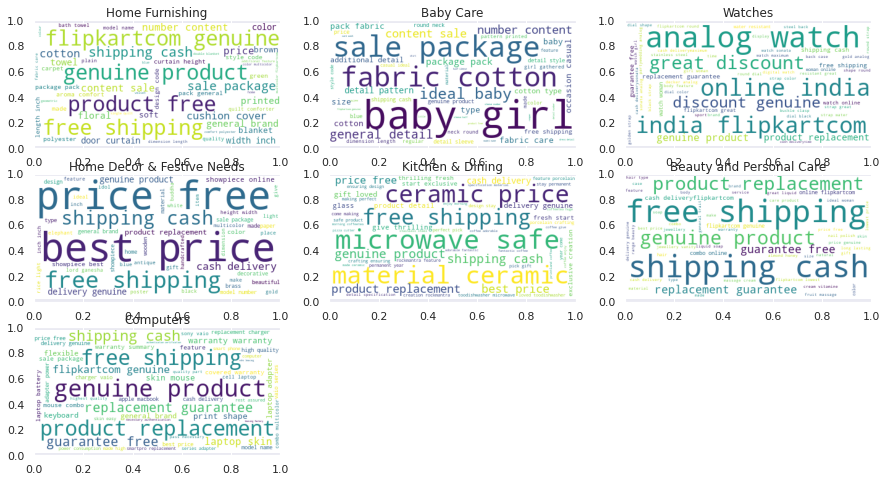

In [21]:
sns.set()
fig, axes = plt.subplots(3,3,squeeze=False)
plt.rcParams["figure.figsize"] = (30,15)

for i in range(0,7):
    ax = fig.add_subplot(3,3,i+1)
    wordcloud = WordCloud(background_color = 'white',max_words=50).generate(df[i])

    ax.imshow(wordcloud)
    ax.axis('off')
    ax.set_title(categories[i])

fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

Plusieurs mots apparaissent plusieurs fois. Après test, il s'avère que les supprimer (et donc les rajouter en tant que stopwords) augmente les performances (de l'ordre de 10% sur notre meilleur modèle).

In [22]:
# Ajout de mots dans les stopwords

# newStopWords = ['width','inch','lenght','flipkartcom','type','height','type']  # Test non concluant
newStopWords = ['width','inch','lenght','flipkartcom','type','height','type','shipping','cash','feature','product','package','sale']
stopwords.extend(newStopWords)                

In [23]:
# Suppression de ces nouveaux stopwords
data['descriptions_nettoyees'] = data['descriptions_nettoyees'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

# Approche Bag of Word  
## Vectorisation

### Count Vectorizer & TfIdF

In [24]:
cv = CountVectorizer(min_df=15,ngram_range = [1,3])
ctf = TfidfVectorizer(min_df=15,ngram_range = [1,3])

cv_transform = cv.fit_transform(data['descriptions_nettoyees'])
ctf_transform = ctf.fit_transform(data['descriptions_nettoyees'])  

In [25]:
# ctf.get_feature_names_out()

In [26]:
print(cv_transform.todense().shape)
print(ctf_transform.todense().shape)

(1050, 545)
(1050, 545)


In [27]:
# # Inutile, on ressort les scores Tf-idf par document

# transformation = []
# for i, score  in enumerate(ctf_transform.todense().tolist()[2]):
#     if score !=0:
#         transformation.append((ctf.get_feature_names_out()[i], score))
# pd.DataFrame(transformation, columns=['mot', 'tfidf']).sort_values(by='tfidf', ascending=False).head(15)

In [28]:
# Exportation de la matrice Tf-idf pour mix textes et images
pd.DataFrame(ctf_transform.todense()).to_csv('Data_textes_tf_idf.csv',sep=',',index=False)

In [29]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels) :
    fig = plt.figure(figsize=(20,8))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categories")
    plt.title('Représentation des catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des catégories par clusters')
    
    plt.show()

In [30]:
l_cat = list(data['First_category'].unique())
print("catégories : ", l_cat)
y_cat_num = [(l_cat.index(data.iloc[i]['First_category'])) for i in range(len(data))]  # Création d'un vecteur avec un numéro par catégorie

catégories :  ['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']


CountVectorizer : 
-----------------
ARI :  0.3099 time :  5.0


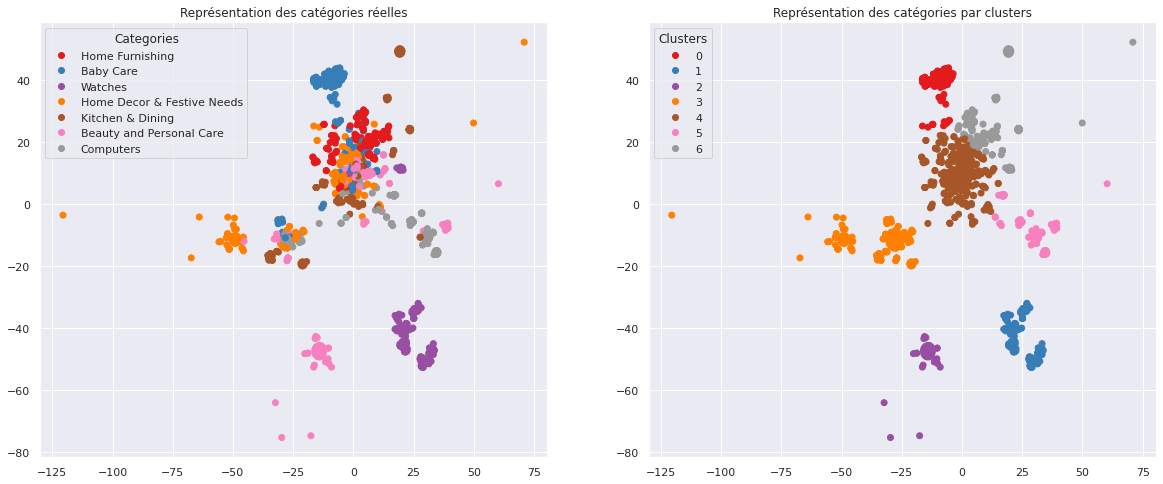

In [31]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)

TSNE_visu_fct(X_tsne, y_cat_num, labels)

Tf-idf : 
--------
ARI :  0.4562 time :  4.0


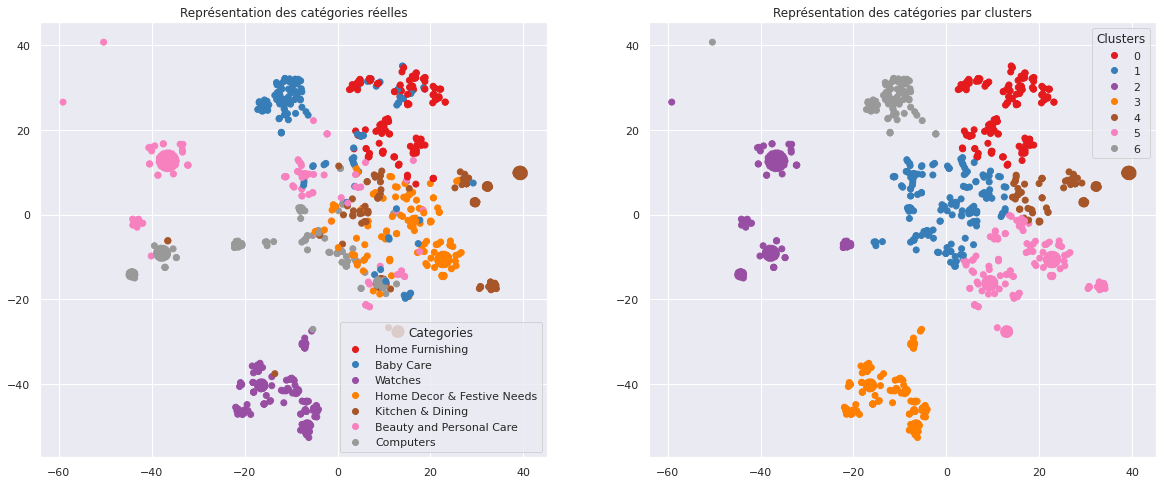

In [32]:
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)
TSNE_visu_fct(X_tsne, y_cat_num, labels)

### Word2Vec

In [33]:
# Calcul du nombre de mots par description
data['Nombre_de_mots'] = data['descriptions_nettoyees'].str.split().str.len()

In [34]:
w2v_size=300
w2v_window=5  # Nombre de mots pris en compte
w2v_min_count=15  # Pour être cohérent du TfIdF
w2v_epochs=100  # Nombre d'itérations sur le corpus (combien de fois l'algorithme voit notre jeu de données)
maxlen = data['Nombre_de_mots'].max()
sentences = data['descriptions_nettoyees'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]  # Créer un array composé des listes de mots par description

In [35]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count,
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,  # Permet d'avoir un modèle plus déterministe (possible que avec workers=1)
                                   workers=1)

w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 528
Word2Vec trained


In [36]:
# Préparation des sentences (tokenization)
# -----------------------
# Normalement, W2V permet de créer un vecteur par mot. Dans notre cas, nous souhaitons avoir un vecteur par descriptions
# On créé donc x_sentences qui est le vecteur par description et non plus par mots
#------------------------
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)  # Updates internal vocabulary based on a list of sequences.
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), # Updates internal vocabulary based on a list of texts.
                            maxlen=maxlen,
                            padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4315


In [37]:
# Création de la matrice d'embedding (sa taille est de 4315,300 : 4315 correspond au nombre de mots unique et 300 car on fixe le nombre de feature du W2V à 300)

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.1224
Embedding matrix: (4315, 300)


In [38]:
# Création du modèle

# input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  # Pour chaque phrase, réalise une moyenne des mots
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          1294500   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,294,500
Trainable params: 1,294,500
Non-trainable params: 0
_________________________________________________________________


2022-07-13 15:54:10.131058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 15:54:10.131265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 15:54:10.131320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-13 15:54:10.131363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-13 15:54:10.131408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [39]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 3ms/step


(1050, 300)

ARI :  0.3848 time :  5.0


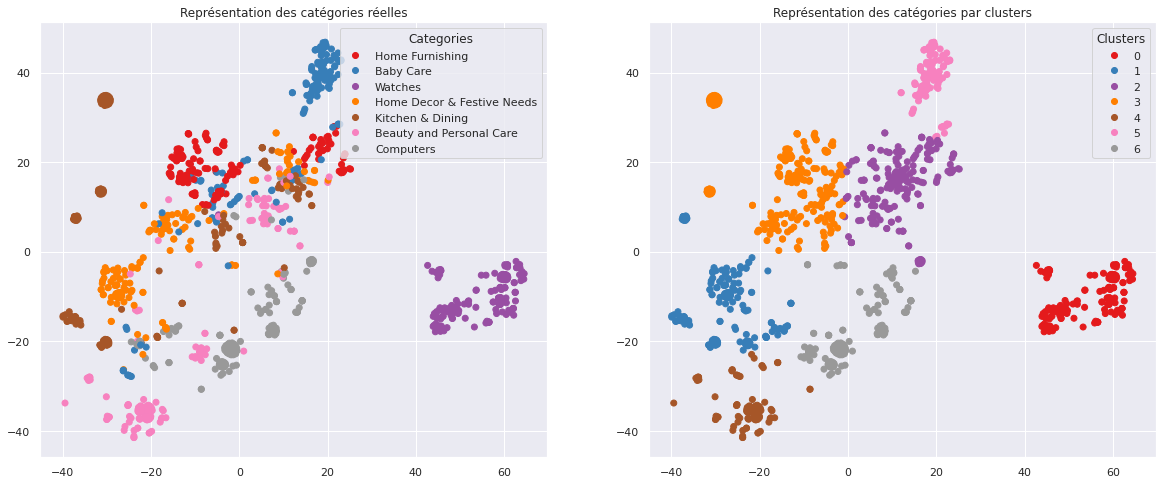

In [40]:
ARI, X_tsne, labels = ARI_fct(embeddings)
TSNE_visu_fct(X_tsne, y_cat_num, labels)

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



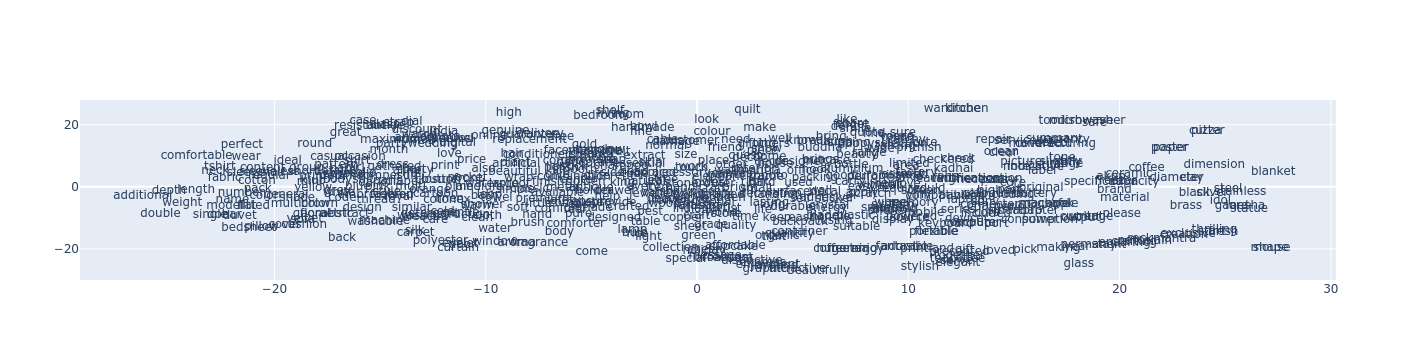

In [41]:
# Affichage du nuage de mots sur une 2D

def apply_TsNE(model):
    # Extrait les mots et les labels
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # Réduction t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

x_vals, y_vals, labels = apply_TsNE(w2v_model)

# Affichage du nuage
trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
iplot([trace])

### Sentence Transformers - SBERT

In [42]:
# SBert est bien plus rapide que Bert (5s vs 65h). Il prend en compte le contexte et réalise un embbedding sur des phrases et non des mots
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2') # Plusieurs bases disponibles
# model = SentenceTransformer('all-mpnet-base-v2')

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

print("Taille de la matrice d'embedding : ", embeddings.shape)

Taille de la matrice d'embedding :  (1050, 384)


ARI :  0.1683 time :  5.0


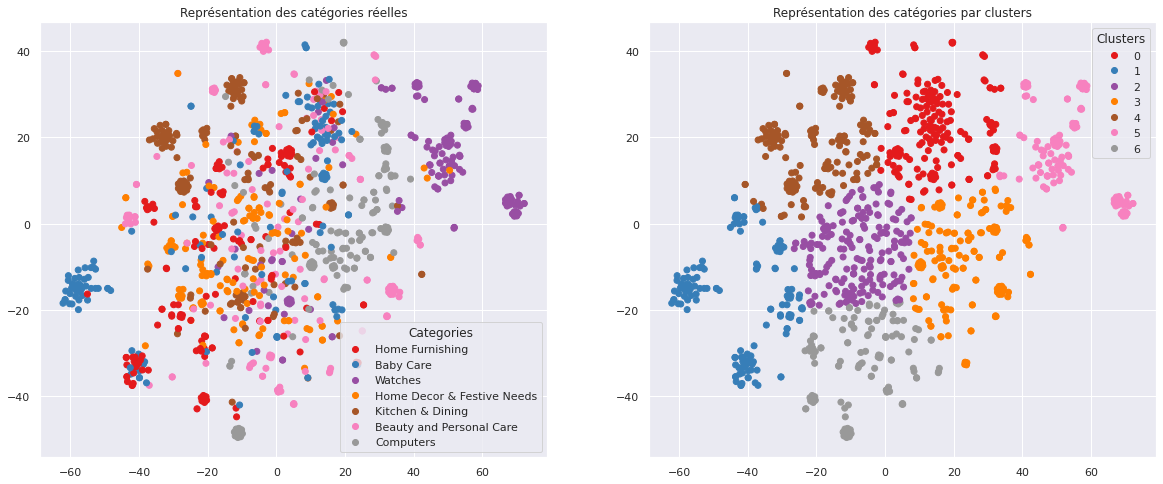

In [43]:
# Calcul ARI et visualisation
ARI, X_tsne, labels = ARI_fct(embeddings)
TSNE_visu_fct(X_tsne, y_cat_num, labels)

## USE - Universal Sentence Encoder

Permet de prendre en compte des phrases et non des mots. Très similaire avec Sbert, la différence réside sur le pré-entrainement des modèles.  
Use a été entrainé from scratch sur plusieurs modèles très variés tandis que Sbert utilise les modèle BERT ou RoBERTa (entrainé sur les corpus Wikipédia)


In [44]:
# Chargement du modèle
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [45]:
def feature_USE_fct(sentences, batch_size) :
    '''
    Fonction permettant de créer une matrice embbeded
    Le batch size doit être congruant de la longeur de sentences si l'on souhaite réaliser un calcul ARI après (sinon la division entière supprime des obsevations)
    -----------
    Entrée : Les sentences sous forme de liste
    -----------
    Sortie : un array avec les embedding
    '''
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])  # Le feat est par tranche de batch_size sentences[50:60] pour batch 10

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [54]:
# Calcul ARI
# Très peu d'influence avec le batch_size. Meilleur perf avec batch_size = 1
batch_size = 1
sentences = data['descriptions_nettoyees'].to_list()

features_USE = feature_USE_fct(sentences, batch_size)
print(features_USE.shape)
ARI, X_tsne, labels = ARI_fct(features_USE)

(1050, 512)
ARI :  0.4185 time :  4.0


In [47]:
# ARI_list = []
# for batch in [1,2,3,5,6,10,14,15,21,25,30,35,42,50,70,75]:
#     features_USE = feature_USE_fct(sentences, batch)
#     ARI, X_tsne, labels = ARI_fct(features_USE)
#     ARI_list.append([batch, " : ", ARI])

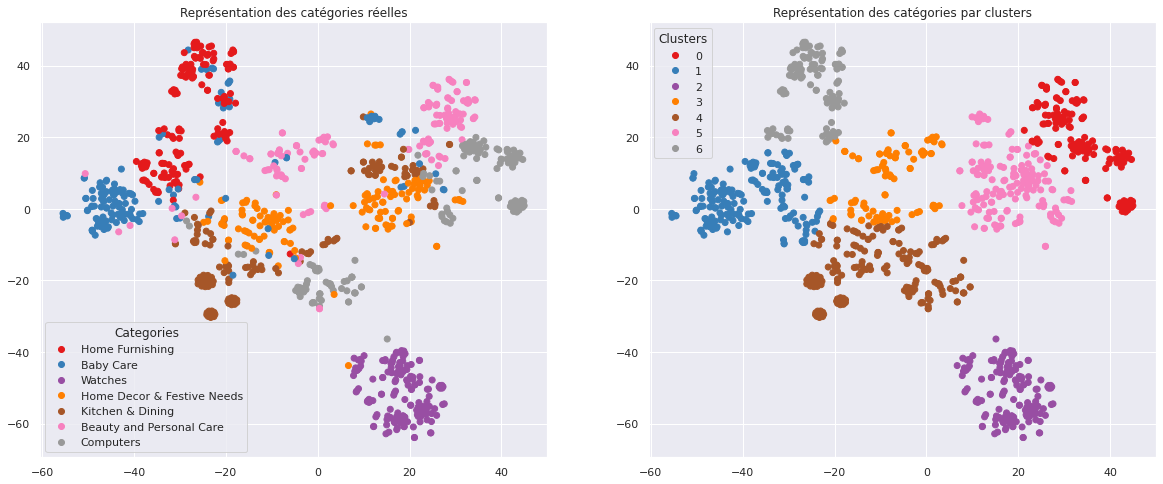

In [48]:
TSNE_visu_fct(X_tsne, y_cat_num, labels)

## LDA

Algorithme permettant de ressortir automatiquement les sujets estimés majeurs.  
Le nombre de sujet est un paramètre d'entrée.

In [49]:
sentences = data['descriptions_nettoyees'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
dictionary = corpora.Dictionary(sentences)
corpus = [dictionary.doc2bow(text) for text in sentences]

ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=7, random_state=42)

In [50]:
ldamodel.print_topics()

[(0,
  '0.021*"watch" + 0.020*"free" + 0.018*"genuine" + 0.018*"delivery" + 0.018*"replacement" + 0.017*"guarantee" + 0.015*"online" + 0.015*"analog" + 0.013*"price" + 0.011*"india"'),
 (1,
  '0.017*"free" + 0.015*"replacement" + 0.015*"delivery" + 0.015*"genuine" + 0.013*"guarantee" + 0.013*"price" + 0.011*"warranty" + 0.010*"online" + 0.009*"color" + 0.009*"laptop"'),
 (2,
  '0.023*"free" + 0.022*"delivery" + 0.022*"genuine" + 0.022*"replacement" + 0.019*"watch" + 0.018*"guarantee" + 0.016*"online" + 0.013*"analog" + 0.010*"price" + 0.009*"india"'),
 (3,
  '0.016*"pack" + 0.016*"price" + 0.013*"color" + 0.011*"baby" + 0.010*"cover" + 0.010*"cotton" + 0.009*"number" + 0.009*"general" + 0.008*"fabric" + 0.008*"replacement"'),
 (4,
  '0.015*"baby" + 0.014*"price" + 0.011*"cotton" + 0.010*"material" + 0.010*"detail" + 0.010*"girl" + 0.010*"perfect" + 0.009*"dress" + 0.008*"free" + 0.008*"general"'),
 (5,
  '0.013*"design" + 0.010*"price" + 0.009*"quality" + 0.008*"pack" + 0.008*"material

In [51]:

os.environ["TOKENIZERS_PARALLELISM"] = "false"


lda_display = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/agent/Logiciels/anaconda3/lib/python3.9/site-packages/past/builtin

## Fin

In [ ]:
# Conservation de la méthode

#------------------------------------------------

def Preprocessing_nettoyage_initial(text):

    preprocessing_list = []
    
    for phrase in text:
        phrase_sans_ponctuation = ''.join([i.lower() for i in phrase if i not in string.punctuation]) # Sans ponctuation et en minuscule
        
        phrase_sans_num = ''.join(i for i in phrase_sans_ponctuation if not i.isdigit()) # Sans chiffre
        
        tokenize_phrase = nltk.tokenize.word_tokenize(phrase_sans_num) # Tokenisation : Transformation des phrases en liste de mots
        
        mots_sans_stopwords = [i for i in tokenize_phrase if i not in stopwords]  # Suppression des stopwords
        
        mots_lemmatize = (lemmatizer.lemmatize(m) for m in mots_sans_stopwords)  # Lemmatisation (non conjugé et non accordé) - préserve le sens: conservation de la racine des mots  -- attention racine = stematisation
        
        phrases_nettoyees = ' '.join(m for m in mots_lemmatize if m.lower() or not m.isalpha())  # Regroupement des mots et suppression des caractères non alphabétiques

        preprocessing_list.append(phrases_nettoyees)        

    return preprocessing_list 

In [ ]:
# Conservation de la méthode

#------------------------------------------------

#data['descriptions_nettoyees'].replace(r'\b\w{1,3}\b','',regex=True,inplace=True) # Suppression des mots de 3 lettres max
#data['descriptions_nettoyees'].replace('  *',' ',regex=True,inplace=True) # Suppression des espaces en trop
#data['descriptions_nettoyees'].replace(r'\s+\b\w{1,3}\b','',regex=True,inplace=True) # Suppression des mots de 3 lettres max sans espace'un espace (\s) + les mots de moins de 3 lettres

In [ ]:
# Conservation de la méthode

#------------------------------------------------

# Application du nettoyage sur la colonne descrition
#descriptions_nettoyees = Preprocessing_nettoyage(data['description'])

#re.sub(r'\b\w{1,3}\b', '', str(descriptions_nettoyees))

# Comparaison de 2 descriptions avant et après transformation
#print('Phrase de base : ' + data['description'][5])
#print('Phrase nettoyée : ' + descriptions_nettoyees[5])